In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv("Data/toi/multiTimeline1.csv", skiprows=2)
# Выполним переименование колонок
df.columns = ['month', 'Dota 2', 'CS GO', 'PUBG']
df

,month,Dota 2,CS GO,PUBG
0,2018-12-30,22,53,60
1,2019-01-06,20,52,59
2,2019-01-13,22,43,55
3,2019-01-20,26,45,56
4,2019-01-27,29,46,61
...,...,...,...,...
255,2023-11-19,38,18,21
256,2023-11-26,26,18,25
257,2023-12-03,24,17,28
258,2023-12-10,48,17,24


In [3]:
# Выведем описание на экран
df.describe()

,Dota 2,CS GO,PUBG
count,260.000000,260.000000,260.000000
mean,30.503846,47.192308,31.784615
std,14.374070,15.207495,10.631769
min,13.000000,14.000000,17.000000
25%,20.000000,38.000000,23.000000
50%,26.000000,44.000000,28.000000
75%,36.250000,51.000000,39.000000
max,82.000000,100.000000,64.000000


In [4]:
df.month = pd.to_datetime(df.month)
df.set_index('month', inplace=True)
df

,Dota 2,CS GO,PUBG
month,,,
2018-12-30,22,53,60
2019-01-06,20,52,59
2019-01-13,22,43,55
2019-01-20,26,45,56
2019-01-27,29,46,61
...,...,...,...
2023-11-19,38,18,21
2023-11-26,26,18,25
2023-12-03,24,17,28


Text(0.5, 0, 'Год')

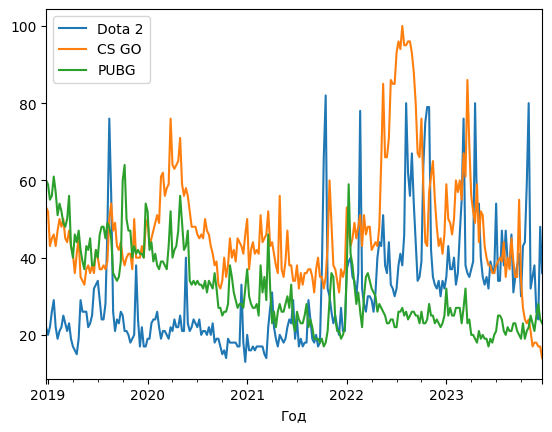

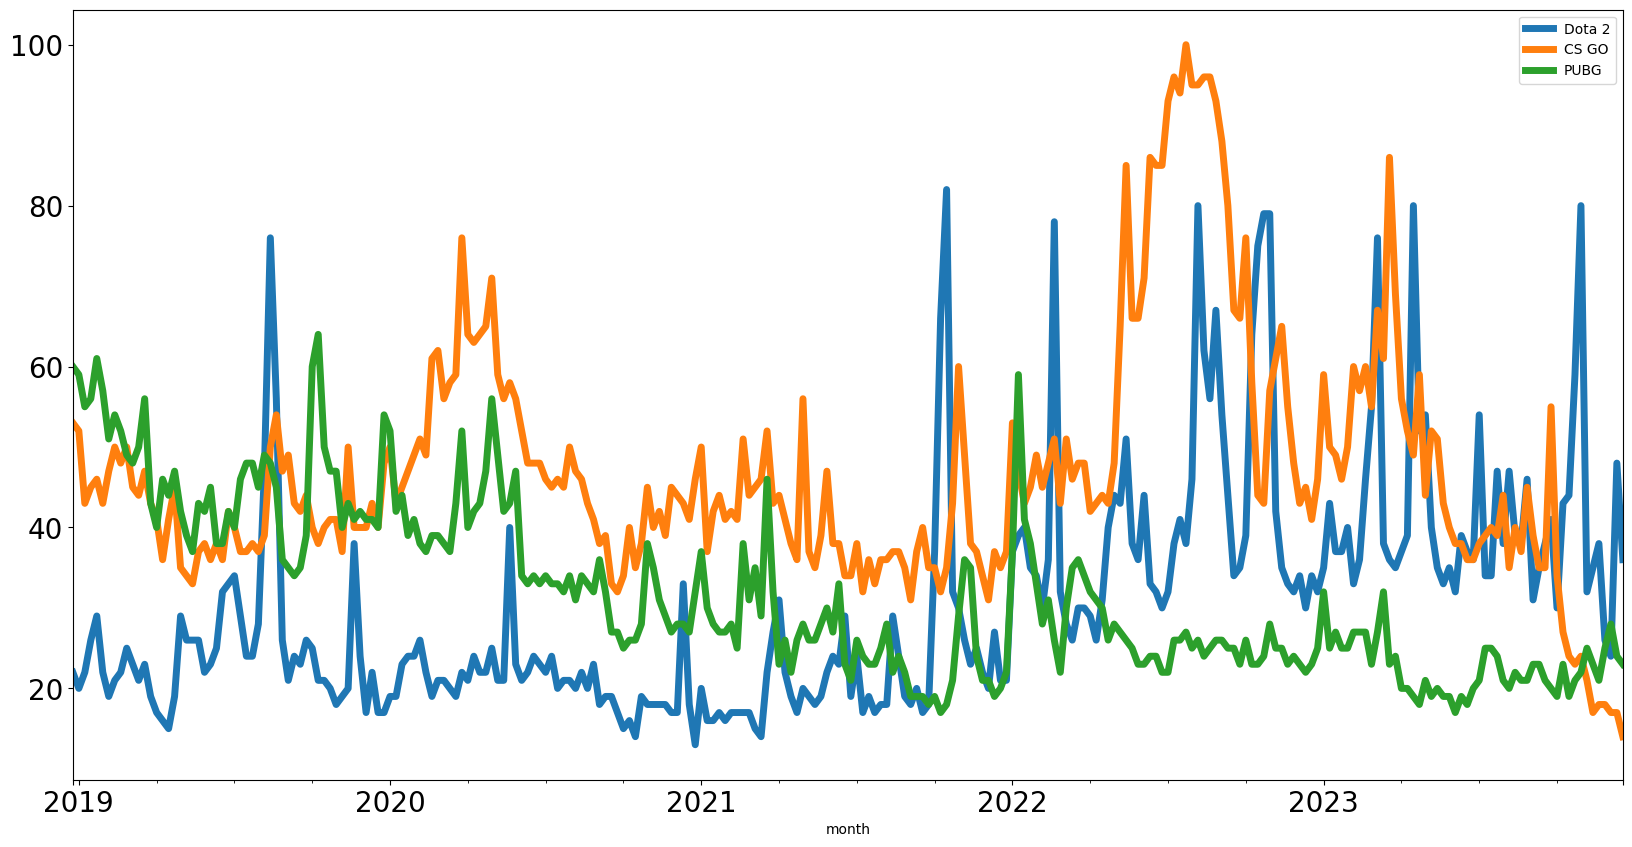

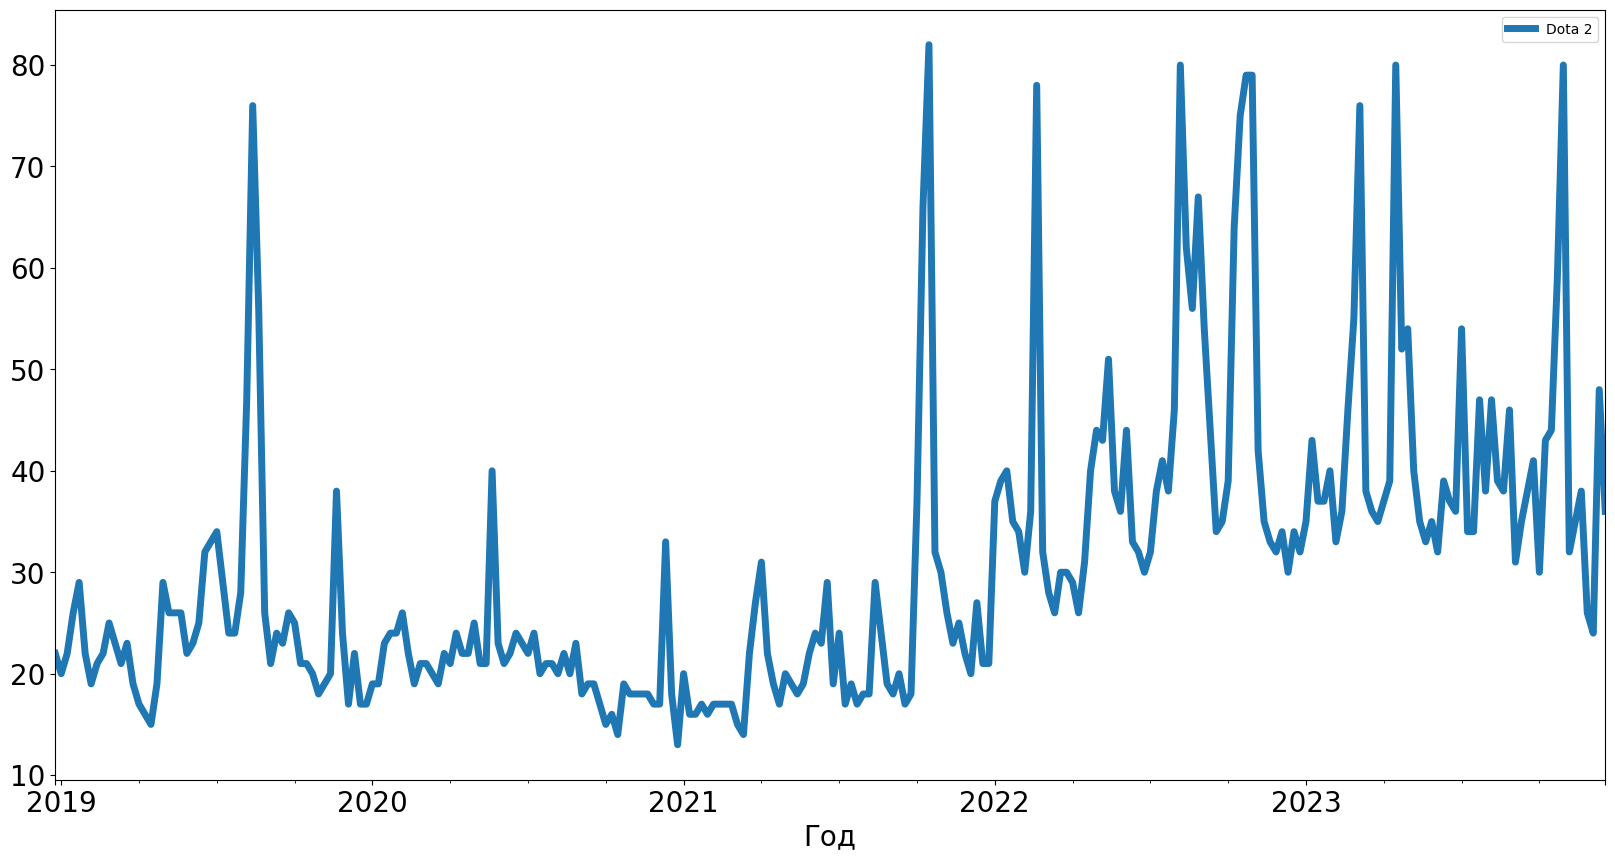

In [5]:
df.plot()
plt.xlabel('Год');
# Изменим параметры рисунка
df.plot(figsize=(20,10), linewidth=5, fontsize=20)
# Выведем на экран один график
df[['Dota 2']].plot(figsize=(20,10), linewidth=5, fontsize=20)
plt.xlabel('Год', fontsize=20)

/var/folders/hh/fhwp4kk9375b4r8jygg93gzc0000gn/T/ipykernel_31838/3456286735.py:2: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  csgo_resamp_yr = csgo.resample('A').mean() # группировка данных по году и вычисление среднего


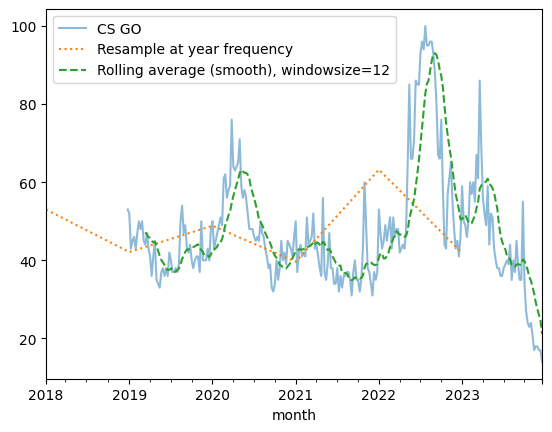

In [6]:
csgo = df['CS GO']
csgo_resamp_yr = csgo.resample('A').mean() # группировка данных по году и вычисление среднего
csgo_roll_yr = csgo.rolling(12).mean() # вычисление скользящего среднего
ax = csgo.plot(alpha=0.5, style='-')  # store axis (ax) for latter plots
csgo_resamp_yr.plot(style=':', label='Resample at year frequency', ax=ax)
csgo_roll_yr.plot(style='--', label='Rolling average (smooth), windowsize=12', ax=ax)
ax.legend()

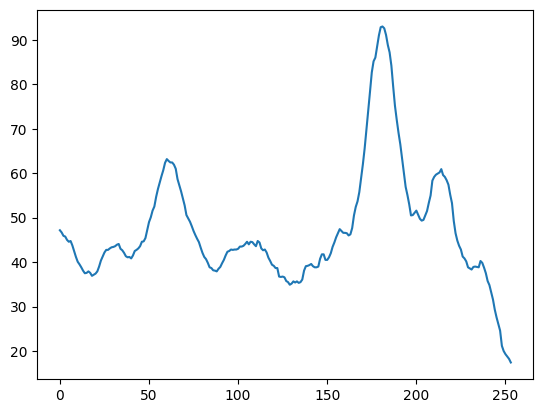

In [7]:
# вычисление скользящего среднего при помощи Numpy
x = np.asarray(df[['CS GO']])
win = 12
win_half = int(win / 2)
csgo_smooth = np.array([x[(idx-win_half):(idx+win_half)].mean()
for idx in np.arange(win_half, len(x))])
plt.plot(csgo_smooth)

Text(0, 0.5, 'Скользящее среднее')

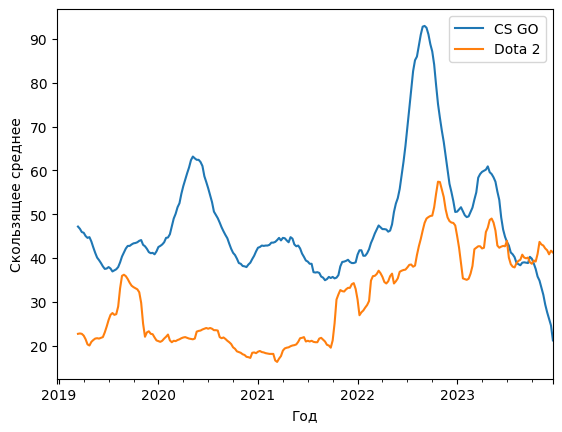

In [8]:
dota = df['Dota 2']
df_avg = pd.concat([csgo.rolling(12).mean(), dota.rolling(12).mean()], axis=1)
df_avg.plot()
plt.xlabel('Год')
plt.ylabel('Скользящее среднее')

Text(0.5, 1.0, 'Вычитание тренда')

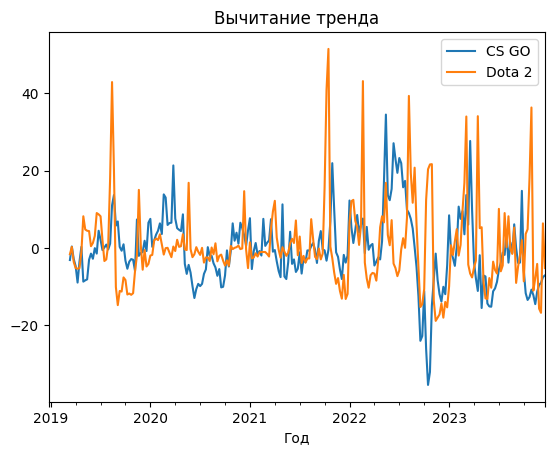

In [9]:
df_dtrend = df[["CS GO", "Dota 2"]] - df_avg
df_dtrend.plot()
plt.xlabel('Год')
plt.title('Вычитание тренда')

Text(0.5, 0, 'Год')

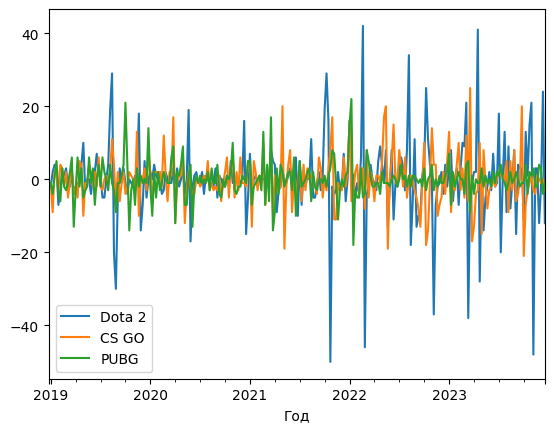

In [10]:
# Разница первого порядка между циклической и сезонной компонентами
assert np.all((csgo.diff() == csgo - csgo.shift())[1:])
df.diff().plot()
plt.xlabel('Год')

In [11]:
print(df.corr()) # расчет корреляции

          Dota 2     CS GO      PUBG
Dota 2  1.000000  0.272995 -0.339199
CS GO   0.272995  1.000000  0.027887
PUBG   -0.339199  0.027887  1.000000


<Axes: >

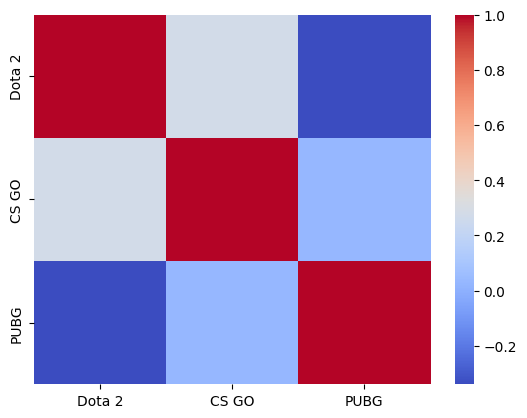

In [12]:
sns.heatmap(df.corr(), cmap="coolwarm")

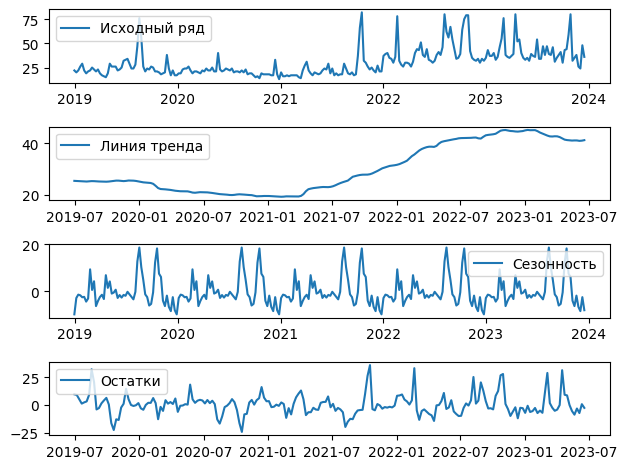

In [13]:
# разложение временных рядов по тренду, сезонности и остаткам
from statsmodels.tsa.seasonal import seasonal_decompose
x = dota
x = x.astype(float) # force float
decomposition = seasonal_decompose(x)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid
plt.subplot(411)
plt.plot(x, label='Исходный ряд')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Линия тренда')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Сезонность')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Остатки')
plt.legend(loc='best')
plt.tight_layout()

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

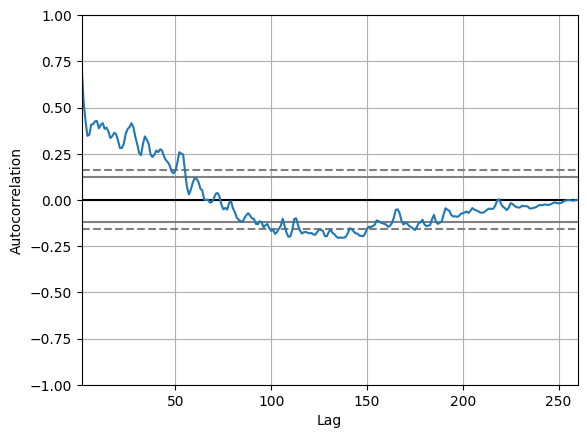

In [14]:
from pandas.plotting import autocorrelation_plot
x = df["Dota 2"].astype(float)
autocorrelation_plot(x)

Text(0.5, 1.0, 'Функция автокорреляции')

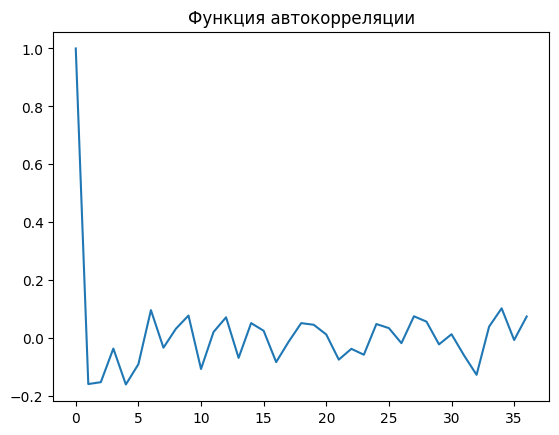

In [15]:
from statsmodels.tsa.stattools import acf
x_diff = x.diff().dropna() # first item is NA
lag_acf = acf(x_diff, nlags=36)
plt.plot(lag_acf)
plt.title('Функция автокорреляции')

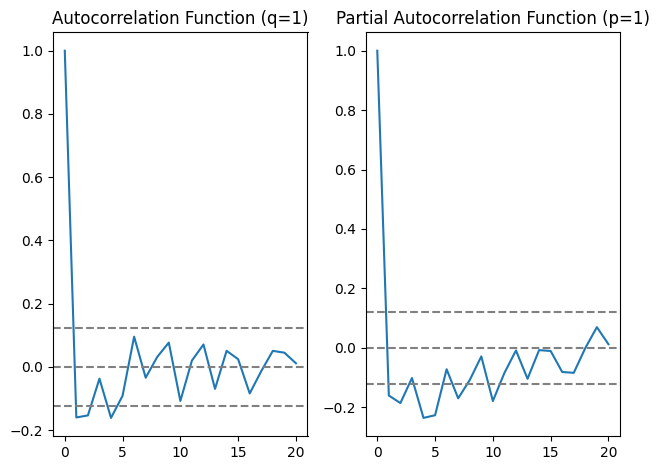

In [16]:
from statsmodels.tsa.stattools import acf, pacf
x = df['Dota 2'].astype(float)
x_diff = x.diff().dropna() # first item is NA
# ACF and PACF plots:
lag_acf = acf(x_diff, nlags=20)
lag_pacf = pacf(x_diff, nlags=20, method='ols')
#Plot ACF:
plt.subplot(121)
plt.plot(lag_acf)
#доверительные интервалы
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(x_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(x_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function (q=1)')
#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(x_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(x_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function (p=1)')
plt.tight_layout()

                               SARIMAX Results                                
Dep. Variable:                 Dota 2   No. Observations:                  260
Model:                 ARIMA(1, 0, 1)   Log Likelihood                -965.303
Date:                Wed, 26 Jun 2024   AIC                           1938.607
Time:                        11:48:02   BIC                           1952.850
Sample:                    12-30-2018   HQIC                          1944.333
                         - 12-17-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         30.5021      3.997      7.631      0.000      22.668      38.336
ar.L1          0.7414      0.061     12.247      0.000       0.623       0.860
ma.L1         -0.0417      0.082     -0.509      0.6

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


Text(0.5, 1.0, 'RSS: 25510.8682')

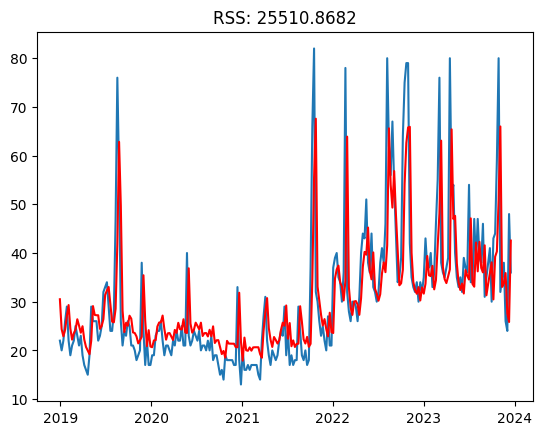

In [17]:
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(x, order=(1, 0, 1)).fit() # подбор модели
print(model.summary())
plt.plot(x)
plt.plot(model.predict(), color='red')
plt.title('RSS: %.4f'% sum((model.fittedvalues-x)**2))